In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *
from ODE_utils import *
from ODE_lag_utils import *

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

In [2]:
class CoUt_alt: # coutilizer
    def __init__(self, rho, g_enz, gC, biomass, id):
        '''
        growth_Rate_list_single: float array[1, N_res]
        gC: float
        biomass: float
        '''
        self.cat = "Cout"
        self.id = id
        self.rho = rho
        self.alive = True
        self.nr = len(g_enz)
        self.g = g_enz # g here is already converted from gaussian and by Terry's physiology
        self.gC = gC
        self.b = biomass
        self.eating = np.array([False for i in range(self.nr)]) # default - not eating anything
    def Dilute(self, D):
        '''
        D: float, dilution factor
        '''
        self.b /= D
        if(self.b<DIEOUT_BOUND):
            self.alive = False
    def GetEating(self, Rs):
        '''
        Rs: float array of all resources
        '''
        self.eating = (Rs>0)
    def GetGrowthRate(self): # growth rate of the sepcies with non-zero resources in R_left
        g_vec = self.g[self.eating]
        n = len(self.g)
        n_eat = np.sum(self.eating)
        if(True not in self.eating):
            return 0
        else:
            return ( ( np.sum(g_vec) * (self.rho*n_eat + (1-self.rho)*n)/n_eat )**-1 + 1/self.gC )**-1
    def GetDep(self):
        '''
        In all cases assume yield Y=1
        Get the fraction of each resource in the biomass gained by this co-utilizer
        '''
        dep = np.zeros(self.nr)
        dep[self.eating] = self.g[self.eating]/np.sum(self.g[self.eating])
        return dep
    
class SeqUt_alt: # sequential utilizer, this time with lags
    def __init__(self, rho, g_enz, gC, pref_list, biomass, id):
        '''
        growth_Rate_list_single: float array[N_res], generated from gaussian
        pref_list: int array[N_res]
        biomass: float
        '''
        self.cat = "Seq"
        self.id = id
        self.gC = gC
        self.rho = rho
        self.alive = True
        self.nr = len(g_enz)
        self.g = g_enz # g here is already converted from gaussian and by Terry's physiology
        self.pref = pref_list
        self.b = biomass
        self.eating = np.array([False for i in range(self.nr)]) # default - not eating anything
        self.lag_from = -1
        self.lag_to = -1
        self.lag_left = 0.0
    def Dilute(self, D):
        '''
        D: float
        '''
        self.b /= D
        if(self.b<DIEOUT_BOUND):
            self.alive = False
    def GetEating(self, Rs):
        '''
        Rs: float array of all resources
        '''
        self.eating = np.array([False for i in range(self.nr)])
        if(self.lag_left==0):
            for r in self.pref:
                if(Rs[r-1]>0):
                    self.eating[r-1] = True
                    break
    def GetGrowthRate(self):
        if(self.lag_left>0):
            return 0
        else:
            n = len(self.g)
            gtilde = self.g * (self.rho + (1-self.rho)*n)
            return (gtilde/(1+gtilde/self.gC)) @ self.eating
    def GetDep(self):
        '''
        In all cases assume yield Y=1
        '''
        return self.eating.astype(float)
    def SetLag(self, taus):
        '''
        taus: np.array(R, R)
        '''
        self.taus = taus
    def GetLag(self, R_dep, Rs): # update lag state after 1 resource gets depleted
        '''
        R_dep: int, the last depleted resource
        Rs: float array of all resources. At this point, R_dep should be 0 in Rs. 
        '''
        if(np.sum(Rs)==0): # if no more resources present, straight up rezero everything
            self.lag_from = -1
            self.lag_to = -1
            self.lag_left = 0.0
            return 0
        if(self.lag_left==0):
            if(self.eating[R_dep-1]>0):
                self.lag_from = R_dep
                for r in self.pref:
                    if(Rs[r-1]>0):
                        self.lag_to = r
                self.lag_left += self.taus[self.lag_from-1, self.lag_to-1]
        else:
            if(R_dep==self.lag_to):
                for r in self.pref:
                    if(Rs[r-1]>0):
                        self.lag_to = r
                self.lag_left += self.taus[self.lag_from-1, self.lag_to-1]
    def LagMoveToNew(self):
        if(self.lag_left!=0):
            self.lag_to = self.pref[0]
        if(self.lag_to == self.lag_from):
            self.lag_left = 0
    def RezeroLag(self):
        self.lag_from = -1
        self.lag_to = -1
        self.lag_left = 0.0

In [3]:
# load the data and make the plot
R = 4
path = "../../ODE-related/seq_vs_co_0213"
path_lag = "../../ODE-related/seq_vs_co_0213_vary_tau"
rhos = np.linspace(0, 0.8, 101)
# get the result for pairwise
all_frac_diaux_pair = []
frac_diaux_pair = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"pairwise_rho={rho}.pkl"), "rb"))
    basic = data["basic"]
    D, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
    states = data["end"]["states"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux_pair.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
all_frac_diaux_pair.append(frac_diaux_pair)

k_list = [0.1, 1.0, 10.0]
for k in k_list:
    frac_diaux_pair = []
    for rho in tqdm(rhos):
        data = pickle.load(open(os.path.join(path_lag, f"pairwise_rho={rho}_lagged_k={k}.pkl"), "rb"))
        basic = data["basic"]
        D, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
        states = data["end"]["states"]
        ids = [i["ids"] for i in states]
        ids_list = sum(ids, [])
        frac_diaux_pair.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    all_frac_diaux_pair.append(frac_diaux_pair)

100%|██████████| 101/101 [00:07<00:00, 14.42it/s]


In [4]:
R = 4
path = "../../ODE-related/seq_vs_co_0213"
path_lag = "../../ODE-related/seq_vs_co_0213_vary_tau"
rhos = np.linspace(0, 0.8, 101)
# get the result for pairwise
all_frac_diaux = []
frac_diaux = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"full_rho={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
all_frac_diaux.append(frac_diaux)

k_list = [0.1, 1.0, 10.0]
for k in k_list:
    frac_diaux = []
    for rho in tqdm(rhos):
        data = pickle.load(open(os.path.join(path_lag, f"full_rho={rho}_lagged_k={k}.pkl"), "rb"))
        states = data["end"]["states"]
        Nseq = data["basic"]["Nseq"]
        ids = [i["ids"] for i in states]
        ids_list = sum(ids, [])
        frac_diaux.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    all_frac_diaux.append(frac_diaux)

100%|██████████| 101/101 [02:00<00:00,  1.19s/it]


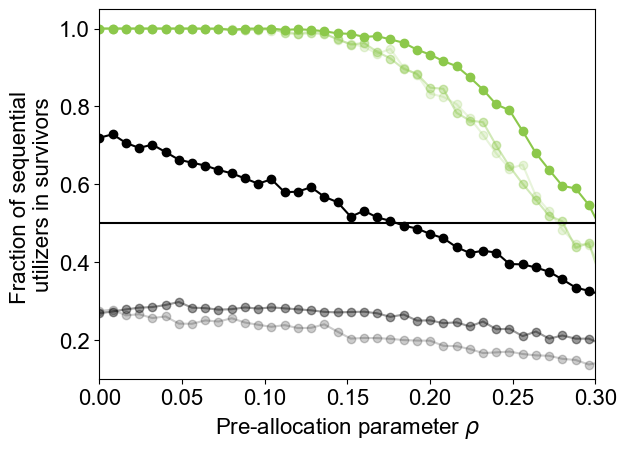

In [6]:
alist = [1.0, 0.4, 0.2]
for idx, frac_diaux_pair in enumerate(all_frac_diaux_pair[:-1]):
    plt.plot(rhos, frac_diaux_pair, marker="o", c="k", alpha = alist[idx])
for idx, frac_diaux in enumerate(all_frac_diaux[:-1]):
    plt.plot(rhos, frac_diaux, marker="o", c="#8CC84B", alpha=alist[idx])

plt.xlabel("Pre-allocation parameter $\\rho$")
plt.ylabel("Fraction of sequential \nutilizers in survivors")
plt.xlim(0, 0.3)
plt.ylim(0.1, 1.05)
plt.axhline(0.5, c='k')

plt.savefig("figs/pairwise_vs_community_lag.pdf")

In [27]:
# maybe take a look at the complementarity:
R = 4
path = "../../ODE-related/seq_vs_co_0213"
path_lag = "../../ODE-related/seq_vs_co_0213_vary_tau"
rhos = np.linspace(0, 0.8, 101)

# get the result for pairwise
all_communities = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"full_rho={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    ids = [i["ids"] for i in states]
    communities = [[species for species in data["end"]["species"][idx] if species.id in idlist] for idx, idlist in enumerate(ids)]
    all_communities.append(communities)
pickle.dump(all_communities, open("../data/dynamics_communities.pkl", "wb"))

100%|██████████| 101/101 [02:03<00:00,  1.22s/it]


In [32]:
R = 4
path = "../../ODE-related/seq_vs_co_0213"
path_lag = "../../ODE-related/seq_vs_co_0213_vary_tau"
rhos = np.linspace(0, 0.8, 101)
# get the result for pairwise
all_frac_diaux = []
frac_diaux = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"full_rho={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    diaux, cout = 0, 0
    for state in states:
        for idx, id in enumerate(state["ids"]):
            if(id<Nseq):
                diaux += state["bs"][-1][idx]
            else:
                cout += state["bs"][-1][idx]
    frac_diaux.append(diaux/(diaux+cout))
all_frac_diaux.append(frac_diaux)

k_list = [0.05, 5.0]
for k in k_list:
    frac_diaux = []
    for rho in tqdm(rhos):
        data = pickle.load(open(os.path.join(path_lag, f"full_rho={rho}_lagged_k={k}.pkl"), "rb"))
        states = data["end"]["states"]
        Nseq = data["basic"]["Nseq"]
        diaux, cout = 0, 0
        for state in states:
            for idx, id in enumerate(state["ids"]):
                if(id<Nseq):
                    diaux += state["bs"][-1][idx]
                else:
                    cout += state["bs"][-1][idx]
        frac_diaux.append(diaux/(diaux+cout))
    all_frac_diaux.append(frac_diaux)

100%|██████████| 101/101 [02:03<00:00,  1.22s/it]


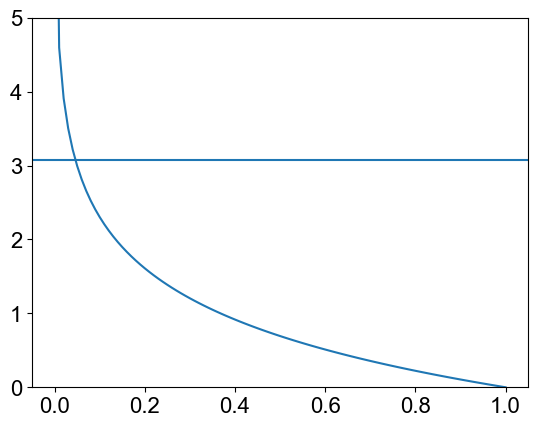

In [21]:
# plot rho vs actual lag
rhos = np.linspace(0.0001, 1, 101)
ktau = 1.0
lags = [-ktau*log(rho) for rho in rhos]
plt.plot(rhos, lags)
plt.ylim(0, 5)
plt.axhline(log(100)/1.5)

In [6]:
log(0.2)

-1.6094379124341003